MNIST Dataset , j'ai telecharger le dataset de kaggle avec le code 


In [1]:
#
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        


In [2]:
#
# Verify Reading Dataset via MnistDataloader class
#
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#

training_images_filepath = 'train-images.idx3-ubyte'
training_labels_filepath ='train-labels.idx1-ubyte'
test_images_filepath = 't10k-images.idx3-ubyte'
test_labels_filepath = 't10k-labels.idx1-ubyte'

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#


In [3]:
x_train_array=np.array(x_train)
y_train_array=np.array(y_train)
x_train_array.shape,y_train_array.shape

((60000, 28, 28), (60000,))

on transformer le data en 2d array matrice pour appliquer les algorithmes 

In [4]:
x_train_array.shape
x_train_array_reshaped=x_train_array.reshape((60000, 28*28))

In [5]:
x_train_array_reshaped.shape

(60000, 784)

Text(0.5, 1.0, 'the number is 4 ')

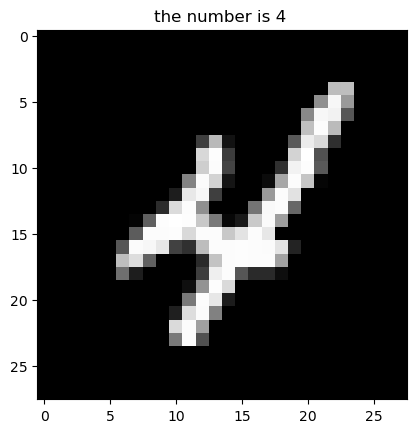

In [6]:
k=9

plt.imshow(x_train_array_reshaped[k].reshape((28,28)),cmap=plt.cm.gray)
plt.title(f"the number is {y_train[k]} ")

## PCA 

Une class pca avec les function de projection et de reconstruction des données

In [7]:

class PCA:
    def __init__(self, n_components):
        self.n_components = n_components  # nombre de composantes principales p
        self.U = None  # matrice des vecteurs propres
    
    def fit(self, X):
        """Étape 1: Récupération de la base (composantes principales)"""
        # Centrer les données
        self.mean = np.mean(X, axis=1, keepdims=True)
        X_centered = X - self.mean
        
        # Calcul de XX^T (matrice de covariance si X est centré)
        XXT = X_centered @ X_centered.T
        
        # Calcul des vecteurs propres via SVD
        # Note: np.linalg.svd retourne U, S, V^T
        U, S, _ = np.linalg.svd(XXT)
        
        # Sélectionner les p premiers vecteurs propres (composantes principales)
        self.U = U[:, :self.n_components]
        
        return self
    
    def transform(self, X):
        """Étape 2 et 4: Encodage des données (entraînement ou test)"""
        X_centered = X - self.mean
        return self.U.T @ X_centered
    
    def inverse_transform(self, Y):
        """Étape 3 et 5: Reconstruction des données"""
        return (self.U @ Y) + self.mean
    
    def fit_transform(self, X):
        """Combinaison de fit et transform pour les données d'entraînement"""
        self.fit(X)
        return self.transform(X)

pour le test on predre les 200 premier digits , avec 

In [8]:
# prender les premier 200 et reverse 
test_data=x_train_array_reshaped[:200].T
# appliquer le pca 
pca=PCA(n_components=20)
pca.fit(test_data)
projected_data=pca.transform(test_data)
reconstructed_data=pca.inverse_transform(projected_data)
reconstructed_data.shape,projected_data.shape

((784, 200), (20, 200))

on visualizer les digit dans le PC1 et le PC2

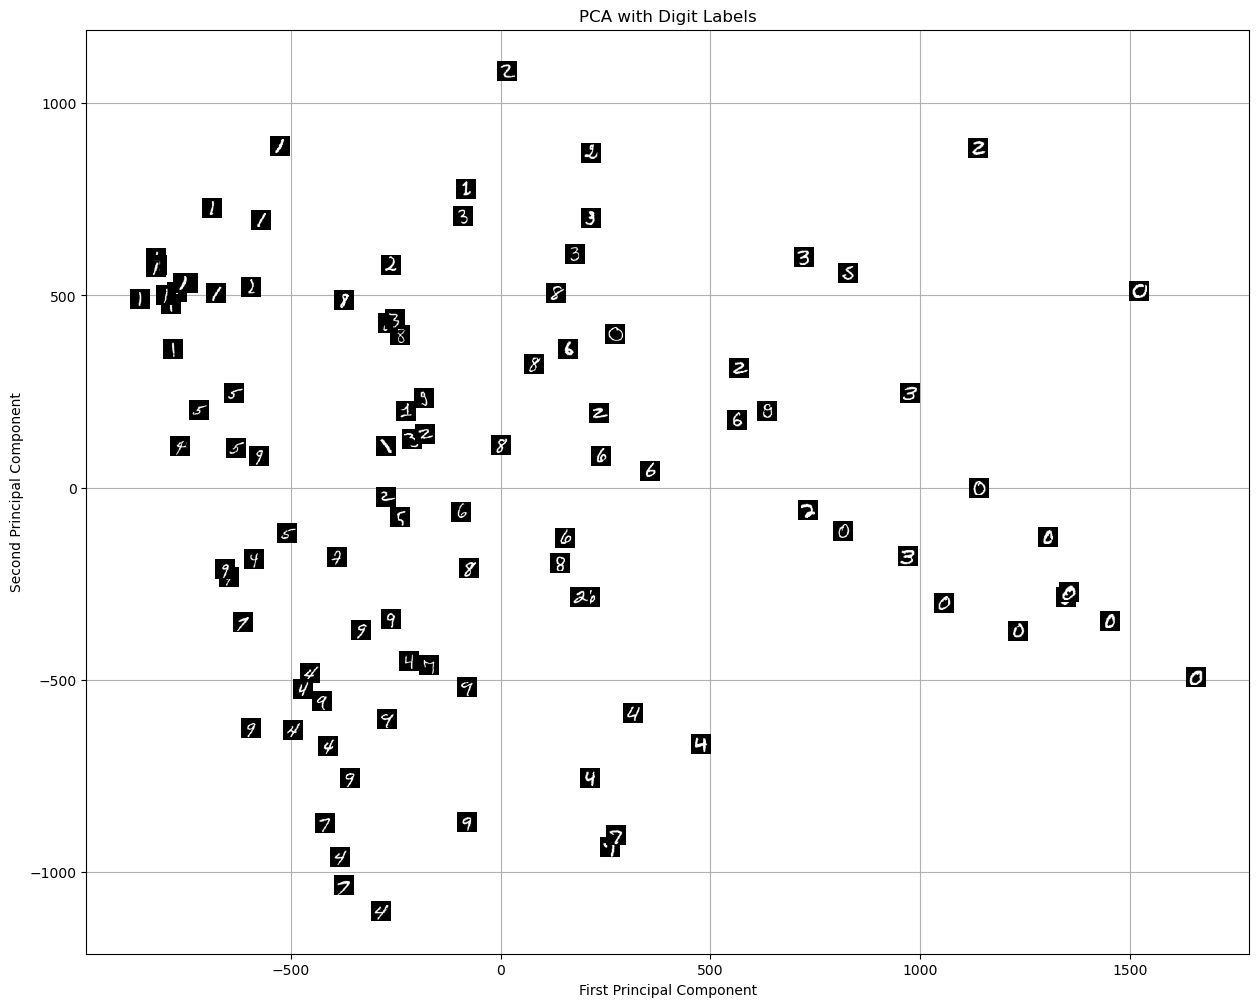

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def plot_pc(projected_data, X=test_data, title='', zoom=0.5, sample_size=100):
    plt.figure(figsize=(15, 12))
    
    # Sample the data if too large (for better visualization)
    if X.shape[1] > sample_size:
        indices = np.random.choice(X.shape[1], sample_size, replace=False)
        projected_data = projected_data[:, indices]
        X = X[:, indices]
    
    ax = plt.gca()
    
    # Create scatter plot (invisible) to set axes limits
    ax.scatter(projected_data[0], projected_data[1], alpha=0)
    
    # Plot each digit image at its PCA coordinates
    for i in range(X.shape[1]):
        # Reshape the image
        img = X[:, i].reshape(28, 28)
        # Create image box
        imagebox = OffsetImage(img, cmap='gray', zoom=zoom)
        # Create annotation box
        ab = AnnotationBbox(imagebox, 
                          (projected_data[0, i], projected_data[1, i]),
                          frameon=False)
        ax.add_artist(ab)
    
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage:
# plot_pc(projected_data, X_train[:, :200], "PCA with Digit Images", zoom=0.4)

plot_pc(projected_data,title= "PCA with Digit Labels")

ici les données apprés la construction avec 20 pca 
on observe que les données reste visible apres no dimuner la dimension 

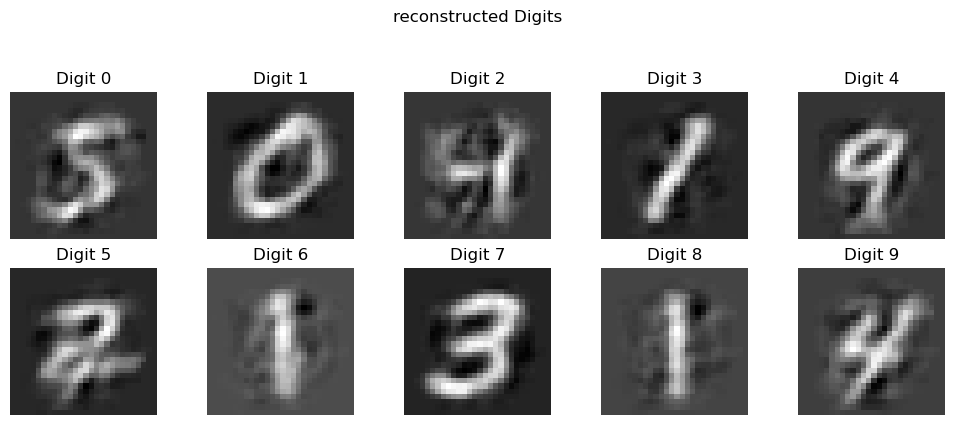

In [18]:
plt.figure(figsize=(10, 4))
for i in range(10):  # Show first 10 digits
    plt.subplot(2, 5, i+1)
    plt.imshow(reconstructed_data[:,i].reshape(28, 28), cmap='gray')
    plt.title(f"Digit {i}")
    plt.axis('off')
plt.suptitle("reconstructed Digits", y=1.05)
plt.tight_layout()
plt.show()


Kernel PCA

In [20]:
class KernelPCA:
    def __init__(self, kernel_func, n_components):
        """
        Parameters:
        kernel_func : fonction noyau (ex: gaussian_kernel)
        n_components : nombre de composantes principales (p)
        """
        self.kernel_func = kernel_func
        self.n_components = n_components
        self.V_p = None          # Vecteurs propres
        self.Sigma_p = None      # Valeurs propres
        self.X_train = None      # Données d'entraînement
        self.K_centered = None   # Matrice noyau centrée

    def fit(self, X):
        """
        1. Récupération de la base (composantes principales)
        Calcule Φ(X)^T Φ(X) via le noyau K
        """
        self.X_train = X
        n = X.shape[1]
        
        # Calcul de la matrice noyau K
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i,j] = self.kernel_func(X[:,i], X[:,j])
        
        # Centrage de la matrice noyau
        one_n = np.ones((n,n))/n
        self.K_centered = K - one_n@K - K@one_n + one_n@K@one_n
        
        # Calcul des vecteurs/valeurs propres
        eigenvalues, V = np.linalg.eigh(self.K_centered)
        
        # Tri décroissant et sélection
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        V = V[:,idx]
        
        # Sélection des p composantes
        self.V_p = V[:, :self.n_components]
        self.Sigma_p = np.diag(np.sqrt(eigenvalues[:self.n_components]))
        
        return self

    def transform(self, X=None):
        """
        2. Encodage des données d'entraînement Y = ΣV^T
        Si X=None, utilise les données d'entraînement
        """
        if X is None:
            return self.Sigma_p @ self.V_p.T
        else:
            return self._transform_new(X)

    def _transform_new(self, X):
        """
        4. Encodage des données test (version vectorisée)
        """
        n_train = self.X_train.shape[1]
        n_test = X.shape[1]
        
        # Calcul de la matrice noyau K_test
        K_test = np.zeros((n_train, n_test))
        for i in range(n_train):
            for j in range(n_test):
                K_test[i,j] = self.kernel_func(self.X_train[:,i], X[:,j])
        
        # Centrage
        one_n_train = np.ones((n_train,n_train))/n_train
        one_n_test = np.ones((n_train,n_test))/n_train
        K_test_centered = K_test - one_n_train@K_test - self.K_centered@one_n_test + one_n_train@self.K_centered@one_n_test
        
        # Encodage
        Y = np.linalg.inv(self.Sigma_p) @ self.V_p.T @ K_test_centered
        return Y

    def fit_transform(self, X):
        """Combinaison de fit et transform"""
        self.fit(X)
        return self.transform()


In [21]:
#kernel fonction 
def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x-y)**2/(2*sigma**2))


In [22]:
KPC=KernelPCA(gaussian_kernel,20)
KPC.fit(test_data)
KPCa_projection=KPC.transform(test_data)

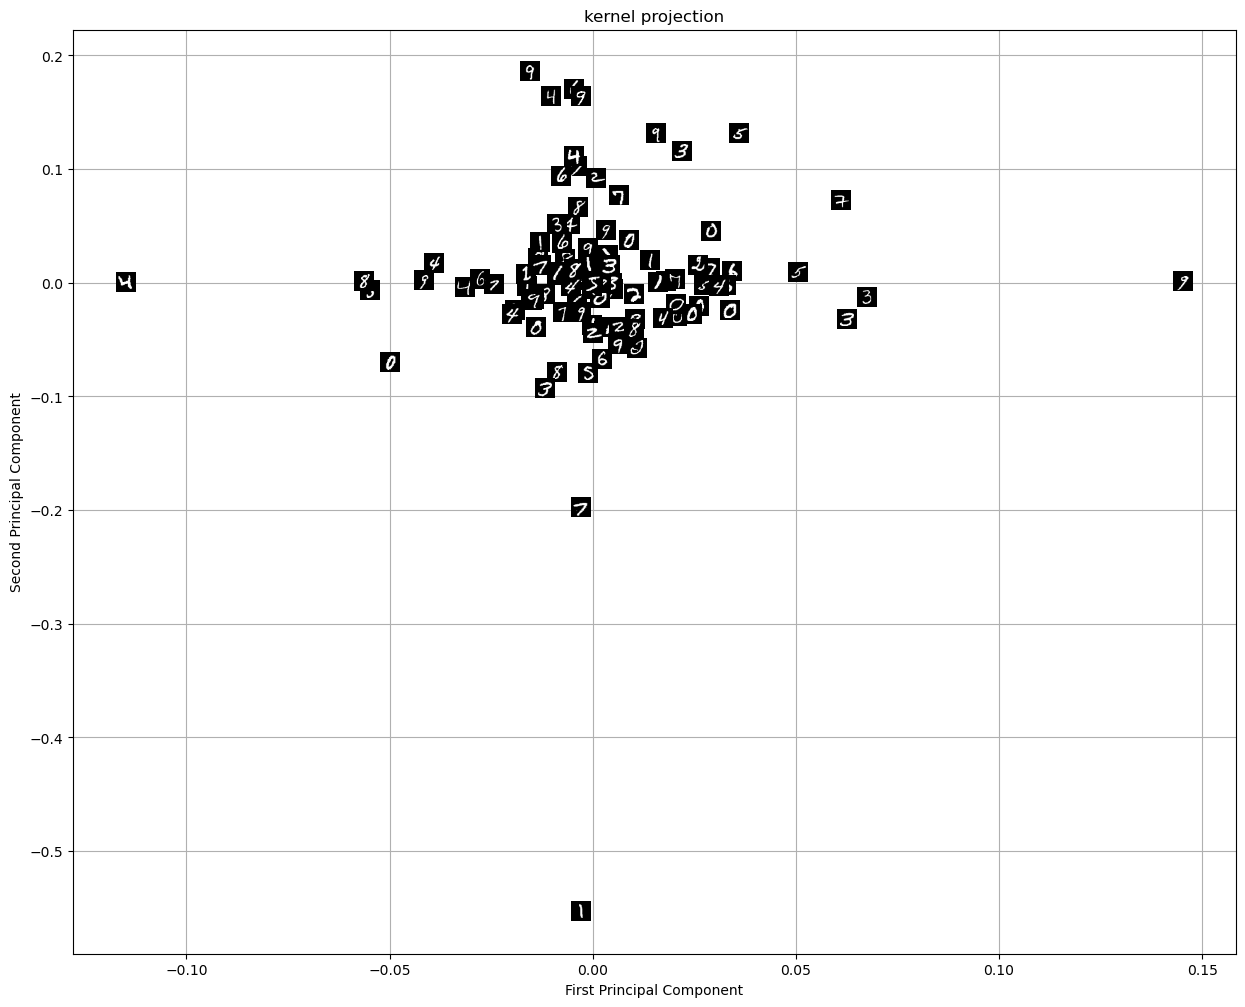

In [24]:
plot_pc(KPCa_projection,title="kernel projection")

## Isomap

In [25]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import shortest_path
class Isomap:
    def __init__(self, n_components=2, n_neighbors=5):
        """
        Paramètres:
        n_components : dimension de l'espace de sortie (défaut: 2)
        n_neighbors : nombre de voisins pour le graphe de voisinage (défaut: 5)
        """
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.dist_matrix_ = None
        self.embedding_ = None

    def fit(self, X):
        """
        Apprentissage du modèle Isomap
        
        Étapes:
        1. Construction du graphe des voisins
        2. Calcul des plus courts chemins (géodésiques)
        3. MDS sur la matrice des distances géodésiques
        """
        # 1. Construire le graphe des k-plus proches voisins
        nbrs = NearestNeighbors(n_neighbors=self.n_neighbors).fit(X)
        distances, indices = nbrs.kneighbors(X)
        
        # Créer une matrice creuse de distances
        n_samples = X.shape[0]
        dist_matrix = np.zeros((n_samples, n_samples))
        
        for i in range(n_samples):
            for j, d in zip(indices[i], distances[i]):
                dist_matrix[i, j] = d
                dist_matrix[j, i] = d
        
        # 2. Calculer les plus courts chemins (distances géodésiques)
        self.dist_matrix_, _ = shortest_path(dist_matrix, 
                                           directed=False, 
                                           return_predecessors=True)
        
        # 3. Appliquer MDS (via Kernel PCA) sur la matrice de distances
        # Centrage double de la matrice de distances
        G = -0.5 * (self.dist_matrix_**2)
        N = G.shape[0]
        H = np.eye(N) - np.ones((N, N))/N
        G_centered = H @ G @ H
        
        # Décomposition en valeurs propres
        eigenvalues, eigenvectors = np.linalg.eigh(G_centered)
        
        # Trier par valeurs propres décroissantes
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # Sélectionner les n_components plus grandes valeurs propres
        self.embedding_ = eigenvectors[:, :self.n_components] * np.sqrt(eigenvalues[:self.n_components])
        
        return self

    def fit_transform(self, X):
        """Apprentissage et transformation des données"""
        self.fit(X)
        return self.embedding_

In [26]:
Isomap_test= Isomap()
isompa_projection=Isomap_test.fit_transform(test_data.T)

In [27]:
isompa_projection.shape

(200, 2)

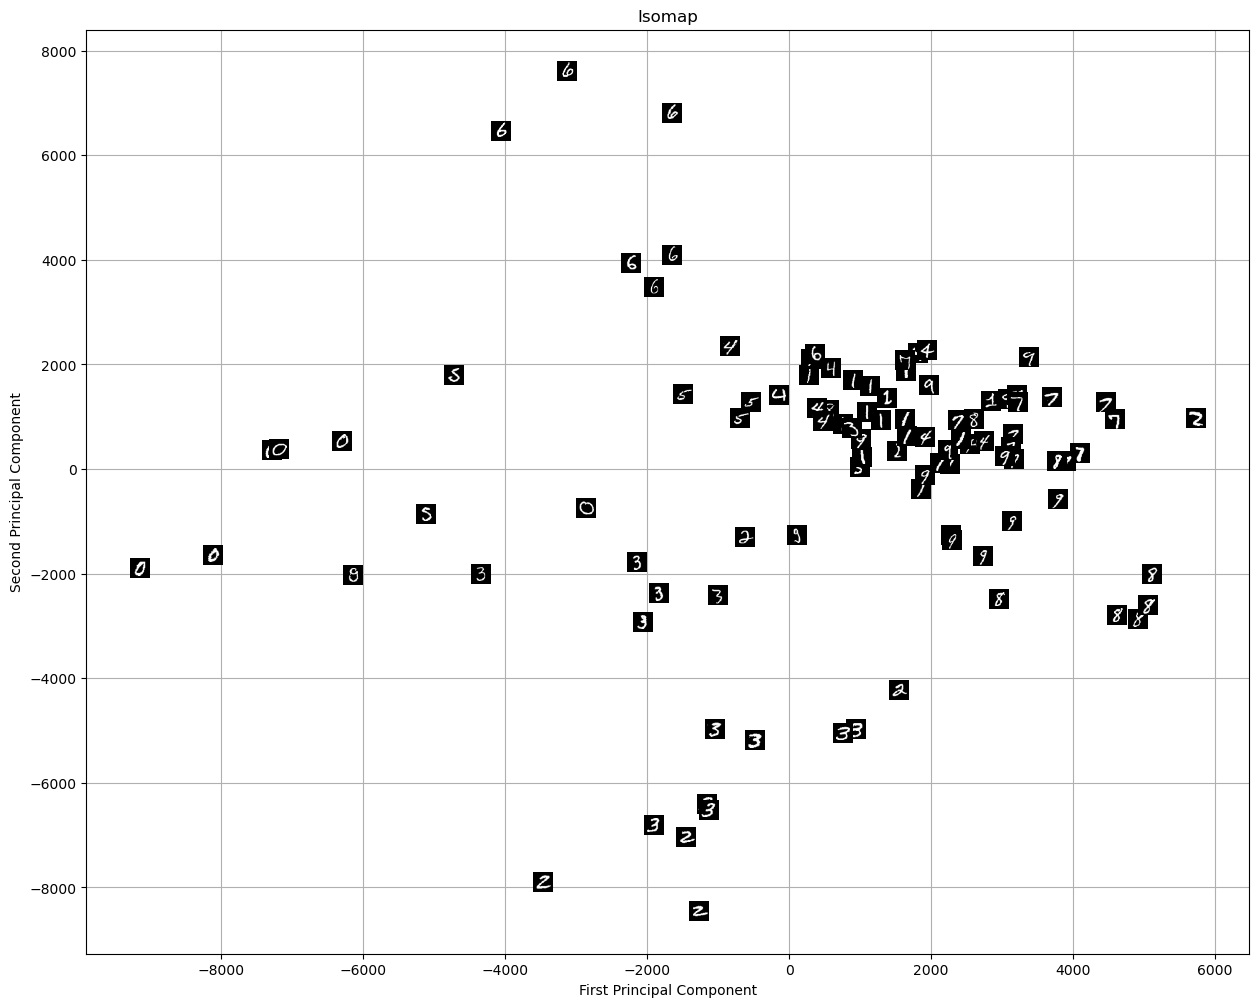

In [29]:
plot_pc(isompa_projection.T,title="Isomap")